In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!nvidia-smi

Mon Nov 20 07:06:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# Преобразование набора данных в YOLO-формат

In [3]:
import json
import os
import shutil
import time

def coco_to_yolo(coco_folder, annotation_file, output_folder_images, output_folder_labels):
    start_time = time.time()
    
    with open(os.path.join(coco_folder, annotation_file), 'r') as f:
        coco_data = json.load(f)

    yolo_annotations = []
    cnt = 0
    
    for image_info in coco_data['images']:
        cnt += 1
        if cnt % 10000 == 0:
            print(f'cnt: {cnt}')
            print()
            
        image_id = image_info['id']
        file_name = image_info['file_name'].split('/')[1]
        width = image_info['width']
        height = image_info['height']

        annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

        yolo_annotation = ""
        
        shutil.copy(os.path.join(coco_folder, 'rtsd-frames/rtsd-frames', file_name), output_folder_images)

        for ann in annotations:
            category_id = ann['category_id'] - 1
            bbox = ann['bbox']

            # Convert COCO bounding box format [x, y, width, height] to YOLO format [x_center, y_center, width, height]
            x_center = bbox[0] + bbox[2] / 2
            y_center = bbox[1] + bbox[3] / 2

            x_center /= width
            y_center /= height
            bbox_width = bbox[2] / width
            bbox_height = bbox[3] / height

            yolo_annotation += f"{category_id} {x_center} {y_center} {bbox_width} {bbox_height}\n"
            
        if yolo_annotation:
            with open(os.path.join(output_folder_labels, file_name.replace('jpg', 'txt')), 'w') as yolo_file:
                yolo_file.write(yolo_annotation)
                
    print(f'elapsed time : {time.time() - start_time} sec')

In [4]:
%mkdir /kaggle/working/data
%mkdir /kaggle/working/data/images
%mkdir /kaggle/working/data/labels
%mkdir /kaggle/working/data/images/train
%mkdir /kaggle/working/data/images/test
%mkdir /kaggle/working/data/labels/train
%mkdir /kaggle/working/data/labels/test

In [5]:
coco_to_yolo(
    '/kaggle/input/rtsd-dataset', 
    'train_anno.json', 
    '/kaggle/working/data/images/train', 
    '/kaggle/working/data/labels/train'
)

cnt: 10000

cnt: 20000

cnt: 30000

cnt: 40000

cnt: 50000

elapsed time : 949.5705816745758 sec


In [6]:
coco_to_yolo(
    '/kaggle/input/rtsd-dataset', 
    'val_anno.json', 
    '/kaggle/working/data/images/test', 
    '/kaggle/working/data/labels/test'
)

elapsed time : 48.172271966934204 sec


In [7]:
with open('/kaggle/working/data/traffic_signs.yaml', 'w') as yaml_file:
        yaml_file.write("train: /kaggle/working/data/images/train\n")
        yaml_file.write("val: /kaggle/working/data/images/test\n")
        yaml_file.write("nc: 155\n")
        yaml_file.write("names: ['2_1', '1_23', '1_17', '3_24', '8_2_1', '5_20', '5_19_1', '5_16', '3_25', '6_16', '7_15', '2_2', '2_4', '8_13_1', '4_2_1', '1_20_3', '1_25', '3_4', '8_3_2', '3_4_1', '4_1_6', '4_2_3', '4_1_1', '1_33', '5_15_5', '3_27', '1_15', '4_1_2_1', '6_3_1', '8_1_1', '6_7', '5_15_3', '7_3', '1_19', '6_4', '8_1_4', '8_8', '1_16', '1_11_1', '6_6', '5_15_1', '7_2', '5_15_2', '7_12', '3_18', '5_6', '5_5', '7_4', '4_1_2', '8_2_2', '7_11', '1_22', '1_27', '2_3_2', '5_15_2_2', '1_8', '3_13', '2_3', '8_3_3', '2_3_3', '7_7', '1_11', '8_13', '1_12_2', '1_20', '1_12', '3_32', '2_5', '3_1', '4_8_2', '3_20', '3_2', '2_3_6', '5_22', '5_18', '2_3_5', '7_5', '8_4_1', '3_14', '1_2', '1_20_2', '4_1_4', '7_6', '8_1_3', '8_3_1', '4_3', '4_1_5', '8_2_3', '8_2_4', '1_31', '3_10', '4_2_2', '7_1', '3_28', '4_1_3', '5_4', '5_3', '6_8_2', '3_31', '6_2', '1_21', '3_21', '1_13', '1_14', '2_3_4', '4_8_3', '6_15_2', '2_6', '3_18_2', '4_1_2_2', '1_7', '3_19', '1_18', '2_7', '8_5_4', '5_15_7', '5_14', '5_21', '1_1', '6_15_1', '8_6_4', '8_15', '4_5', '3_11', '8_18', '8_4_4', '3_30', '5_7_1', '5_7_2', '1_5', '3_29', '6_15_3', '5_12', '3_16', '1_30', '5_11', '1_6', '8_6_2', '6_8_3', '3_12', '3_33', '8_4_3', '5_8', '8_14', '8_17', '3_6', '1_26', '8_5_2', '6_8_1', '5_17', '1_10', '8_16', '7_18', '7_14', '8_23']\n")

# Train

In [8]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16066, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 16066 (delta 2), reused 3 (delta 0), pack-reused 16056
Receiving objects: 100% (16066/16066), 14.68 MiB | 26.23 MiB/s, done.
Resolving deltas: 100% (11030/11030), done.


In [9]:
%cd yolov5

/kaggle/working/yolov5


In [10]:
!pip install -r requirements.txt

  Obtaining dependency information for ultralytics>=8.0.147 from https://files.pythonhosted.org/packages/c3/a0/149b7cbad47352582a7fc5ae48fae0f65b64b8111d2aca6bef314077c371/ultralytics-8.0.213-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.3/645.3 kB 16.4 MB/s eta 0:00:0000:01


In [11]:
# !python train.py --img 1280 --batch -1 --epochs 1 --data /kaggle/working/data/traffic_signs.yaml --weights yolov5s.pt --device 0
!python -m torch.distributed.run --nproc_per_node 2 train.py --img 1280 --batch 30 --epochs 8 --data /kaggle/working/data/traffic_signs.yaml --weights yolov5s.pt --device 0,1

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/kaggle/working/data/traffic_signs.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=8, batch_size=30, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0,1, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with

In [12]:
!python detect.py --source /kaggle/working/data/images/test --weights /kaggle/working/yolov5/runs/train/exp/weights/best.pt --save-txt --save-conf --name "yolov5s_signs_test" --imgsz 1280 --conf-thres 0.25

detect: weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], source=/kaggle/working/data/images/test, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolov5s_signs_test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 11.0s, installed 1 package: ['Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-243-g7c54e5d Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7428160 parameters, 0 gradients, 17.1 GFLOPs
image 1/5000 /kaggle/working/da

# Inference

requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, attempting AutoUpdate...


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master



requirements: AutoUpdate success ✅ 10.7s, installed 1 package: ['Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 v7.0-243-g7c54e5d Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7428160 parameters, 0 gradients, 17.1 GFLOPs
Adding AutoShape... 


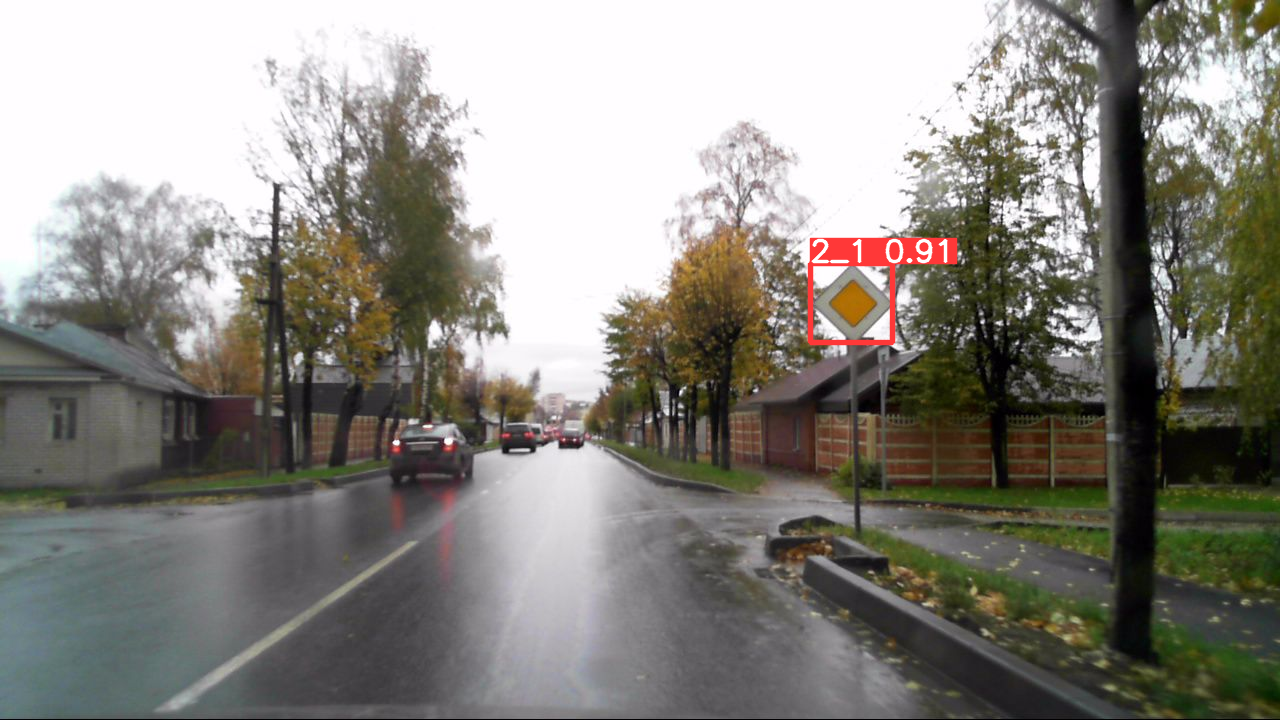

In [32]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

model = torch.hub.load(
    'ultralytics/yolov5',
    'custom',
    path='/kaggle/working/yolov5/runs/train/exp/weights/best.pt'
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

img = '/kaggle/working/data/images/test/autosave10_10_2012_12_51_22_2.jpg'  
results = model(img)
results.show()

In [51]:
results

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 720x1280 1 2_1
Speed: 7.5ms pre-process, 8.5ms inference, 1.5ms NMS per image at shape (1, 3, 384, 640)

# Metrics

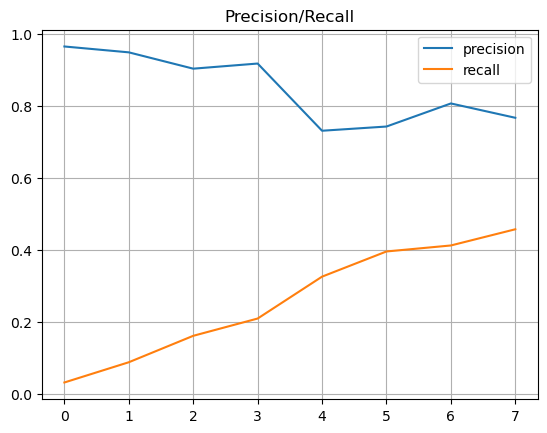

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

metrics = pd.read_csv('C:/Users/Xiaomi/Downloads/results.csv')

plt.plot(
    metrics['               epoch'],
    metrics['   metrics/precision'],
    label='precision'
)
plt.plot(
    metrics['               epoch'],
    metrics['      metrics/recall'],
    label='recall'
)
plt.grid()
plt.title('Precision/Recall')
plt.legend()

# Gradio

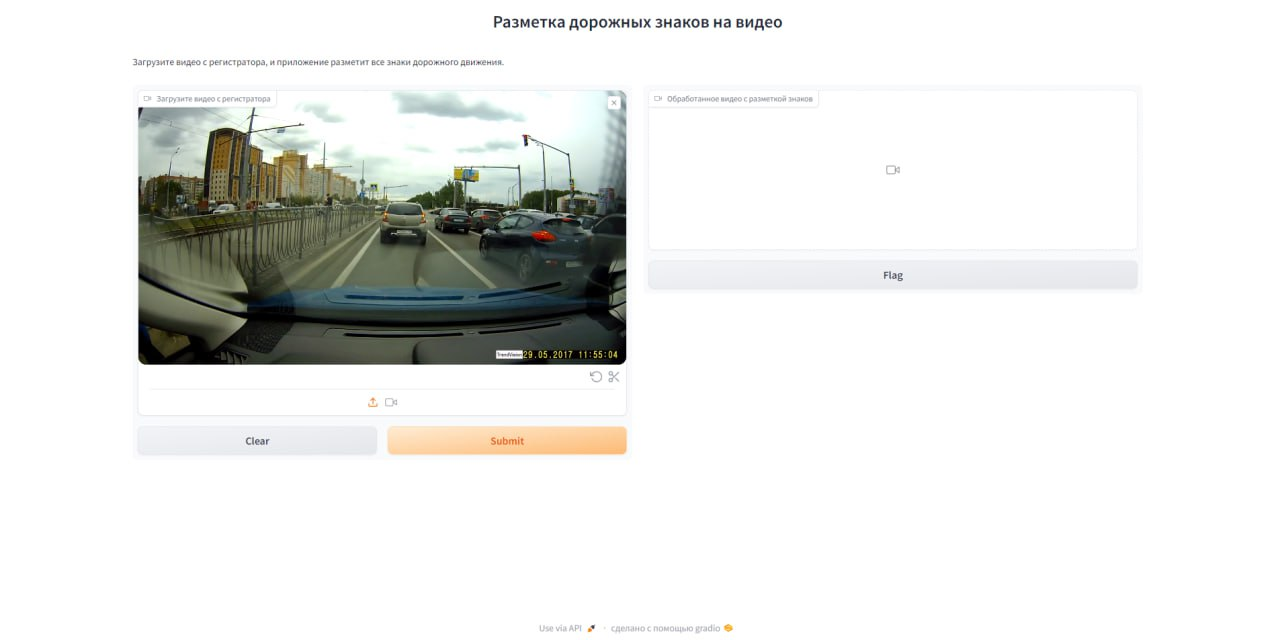